# 2. Bayesian A/B Testing
In this post we are going to discuss Bayesian Methods and their application to Bayesian A/B testing. In particular we will:
* Look at the shortcomings of standard frequentist A/B testing
* Motivate why Bayesian Methods are an improvement
* Implement Bayesian A/B Testing in code

Note that I am writing with the assumption that you have gone through my post on statistical inference and frequentist A/B testing, or are very comfortable with both of those topics. With that out of the way, let's get started.

## 1. Drawbacks of Frequentist A/B Testing
To begin, consider the following example:

> A drug you are testing is working well-can you stop the test and improve quality of life of all participants? 

Standard frequentist statistics would say _no_. This is because it is bad to stop early when doing frequentist statistics, since it increases the chances that you reach a false positive conclusion. Remember, the $p$-value can pass below/above the threshold over time. Clearly this can be a shortcoming in many scenarios, and in some even go as far as being deadly. 

### 1.1 Multi-Armed Bandit
Now, imagine the following scenario, commonly referred to as the **Multi-Armed Bandit** problem: You are at the casino playing slots (hence the term arm). The slot machines are bandits because they are taking your money. Not all of the slots machines are equal. Specifically: 
* 1 pays out 30% of the time
* 1 pays out 20% of the time
* 1 pays out 10% of the time 

This is the same problem as the click-through or conversion rate! Only now we would substitute click for getting a prize. So, if we wanted to find out what arm we should pull the receive the largest payout over time, we would setup an A/B test, run the experiment, and by the end you would know if any one arm was significantly better than the others. In other words, we would run the A/B test for a specific number of $N$ trials, then calculate the $p$-value.

Now, let me ask another question: what would you do in real life? For instance, say that 1 arm gives you a prize 3 out of 3 times, and the other arm gives you a prize 0 out of 3 times. Well, most people (myself included) would intuitively play the arm that payed out 3 times! Why is this? Because we _adapt_. Even though three plays for each arms is most likely not enough to gain statistical significance, most people still feel compelled to believe that the first arm is better. 

### 1.2 Reinforcement Learning
If you have gone through my posts on AI you will certainly have seen those related to Reinforcement Learning, which faces the same problem that we are here. Specifically, in RL we are trying to teach a machine to play a game. It models rewards it gets based on the actions it takes. The problem is that this process is **stochastic** and your model of the rewards is only an estimate (it is not feasible to try every possible action, in every possible state). In general, early on there are few actions to take, and the machine is unsure about most of the rewards. It can't "choose the action that leads to the best reward", because the knowledge about rewards is currently minimal. Only after collection a lot of data will the estimate be accurate. 

### 1.3 Explore vs. Exploit
This problem that we are dealing with has a name: **The Explore-Exploit Dilemma**. We can use this name to frame the following question: 

> If we have gotten 3/3 on bandit 1, and 0/3 from bandit 2, should we:
* **Exploit** bandit 1 more?
* **Explore** at random to gather more data?

This is the problem that we are going to be trying to solve in this post. We will look at several solutions, all of which are _adaptive_, but only some will be Bayesian. We will show the bayesian method last. 

## 2. Adaptive Learning Methods

### 2.1 Epsilon-Greedy Solution 
One method of solving the explore-exploit dilemma is called the **epsilon-greedy** algorithm (and it is intuitive). It just so happens that this algorithm is also used in reinforcement learning. Here is how it works:

> Say you have some software that is serving 2 advertisements ($A$ & $B$), you will *not* run a full A/B test by blindly serving ad $A$ and ad $B$ an equal number of times. Instead you will adapt to the data you have collected. If ad $A$ is performing better, it will be shown more often. 

Note: even with this adaptive system, you can still do traditional A/B test after collecting data. Remember the contingency table for the chi-square test doesn't require both samples to be the same size. The thing changing here is not the test, but the machine that serves the ads. It will adapt based on the performance of each ad. 

#### How does it work?
It is simpler than it sounds! We start by choosing a small number epsilon ($\epsilon$) between 0 and 1 which will serve as our _probability of exploration_. Typical values are 5% or 10%. In pseudocode it may look like:

```
epsilon = 0.1 
while True:
    r = rand()
    if r < epsilon:
        # explore
        # show random advertisement
    else:
        # exploit
        # show best advertisement (as determined by #clicks/#impressions)
```

#### Analyis of Epsilon-Greedy
We can clearly see that that was pretty simple, so let's analyze further. One problem is that this algorithm does the same thing *forever*. For instance, even when ad $A$ is statistically significantly better than $B$, it will still sometimes choose $B$. Suppose the test has converged, $A$ is better than $B$, how much reward will we get? If we say that:

$$reward(click) = 1 \;,\; reward(noclick) =0$$

Then after $N$ impressions:

$$reward = N(1-\frac{\epsilon}{2})$$

In other words, for $\epsilon = 0.1$, we get $0.95N$ instead of $N$. However, this is still better than traditional A/B testing with no adaptation.


### 2.2 UCB1
Alright, so we have now looked at one adaptive learning method. The question is, can we improve upon it? To find out, let's look at the **UCB1** algorithm. Recall earlier discussions about confidence intervals. We determined an upper and lower limit to represent where we believe the true CTR is. We'll now look at a very similar idea, but we are not going to use the confidence bound we discussed before.

If you are unsure how confidence intervals relate to the scenario at hand, considering the following: Intuitively, we know that if you collect 10 samples and take the mean, this is not as accurate as if you collect 1000 samples and take the mean. If you were to draw a confidence bound around the 10 sample mean, it would be much wider than that which was around the 1000 sample mean. This concept can be used algorithmically in order to dynamically update when each advertisement should be served.

Now, to be clear, we are not going to be using the exact same confidence interval that we have worked with before. Rather, we are going to use a _tighter_ bound,: the **Chernoff-Hoeffding** bound. It says for some:

$$\epsilon > 0$$

That the following probability inequality is true:

$$P \big(\hat{\mu}>\mu+\epsilon \big) \leq e^{-2\epsilon^2N} $$

It also follows that the opposite side is also true:

$$P \big(\hat{\mu} < \mu+\epsilon \big) \leq e^{-2\epsilon^2N}  $$

Note, this bound is a little different from the confidence interval that we have seen before. Namely, the confidence interval gave us specific numbers, and said that the probability that the true parameter lied within that interval was 95% (this isn't _entirely accurate_, but is an approximate description):

$$P(\text{lower bound} < \mu < \text{upper bound} ) = 95\%$$

On the other hand, our new equation says that:

$$P(\mu \text{in interval}) > f(N)$$

Or in english, "the probability that the true parameter lies within this range is greater than some function of $N$". In order to get the greater than sign, we just need to combine and arrange the two probabilities:

$$P(\hat{\mu} - \mu > \epsilon) \leq e^{-2\epsilon^2N}  \longleftrightarrow P(\hat{\mu} - \mu \leq \epsilon) > 1 - e^{-2\epsilon^2N} $$

$$P(\hat{\mu} - \mu < - \epsilon) \leq e^{-2\epsilon^2N}  \longleftrightarrow P(\hat{\mu} - \mu \geq - \epsilon) > 1 - e^{-2\epsilon^2N} $$

$$P \big( |\hat{\mu} - \mu| \leq \epsilon \big) > 1 - 2 e^{-2\epsilon^2N} $$

#### Upper Confidence Bound
In any case, for us we are only interested in the upper bound, because we want to get the highest reward possible. How exactly does this help us? Well, intuitively if we have a tighter upper bound, we can be more confident above that maximum possible win rate of any bandit. We are skipping some math here, but essentially for any arm $j$, we "choose" $\epsilon$ to be:

$$\epsilon_j = \sqrt{\frac{2 lnN}{N_j}}$$

Where $N$ is the total number of games played so far, and $N_j$ is the total times that arm $j$ has been played. We can define the upper confidence bound via:

$$\mu_{UCB-j} = \hat{\mu}_j + \epsilon_j$$

$$\mu_{UCB-j} = \hat{\mu}_j + \sqrt{\frac{2 lnN}{N_j}}$$

So, in other words, we are picking whichever bandit arm gives us the largest _upper confidence bound_ for any given turn. Again, as with epsilon-greedy, we will be using a greedy strategy. However, we are not simply greedy with respect to the sample mean $j$, but rather the upper confidence bound of the sample mean. In psuedocode, we would have:

```
N = 0
N_j = 0 for all bandits j

while True:
    j* = argmax(mu_j + sqrt( (2ln(N)) / (N_j) ))
    Play arm j*
    Update mu_j*
    N++; Nj*++
```

In english the above can be described as follows:
1. We set $N$ and $N_j$ equal to 0, for all bandits $j$.
2. Then, in a loop, we get the $argmax$ of the estimated mean, $\hat{\mu}$, plus the epsilon that we just defined, $\epsilon_j = \sqrt{\frac{2 lnN}{N_j}}$. In other words, we choose the bandit with the highest upper bound.
3. We play that bandits arms, and then we update the estimated mean for that arm, $\hat{\mu}_j$.
4. Finally, we increment $N$ and $N_j$.

#### How does this help with the Explore vs. Exploit problem?
You may look at this algorithm and wonder how it helps us explore and exploit. Well, let's look at where the main logic of this algorithm is held, the following line:

$$j^* = argmax \Big( \hat{\mu}_j + \sqrt{\frac{2 lnN}{N_j}} \Big)$$

Let's now look at each term individually. The first term is just the estimated mean:

$$\hat{\mu}_j$$

If that is high, then we will be exploiting it more often. If you look at the second term:

$$\sqrt{\frac{2 lnN}{N_j}}$$

You will see that it depends on $N$, the total number of plays, and $N_j$, the number of plays for arm $j$. If $N$ is large while $N_j$ is low, then that will encourage us to explore arm $j$ more, because it increases the upper confidence bound. We also should consider the asymptotic behavior of:

$$\frac{ln(N)}{N}$$

Above, as $N \rightarrow \infty$, $\frac{ln(N)}{N}$ approaches 0, so we use only the true CTR (estimated means) when $N$ is large.

We can see that from a coding/implementation perspective, this is no more complex than the epsilon-greedy algorithm. The right question to ask at this point, however, is what is our expected loss from this algorithm. With a good deal of math it can be shown that the loss is proportional to $ln(N)$. Compare this to epsilon-greedy where the loss is proportional to $N$. This means that in the long run, **UCB1** will perform much better than epsilon-greedy.

## 3. Bayesian Adaptive Learning

### 3.1 Bayesian Paradigm
We are finally approaching the point of implementing full blown bayesian learning. But before we do, I think it would be useful to make a distinction as to what the Bayesian Paradigm really is, and how it differs from the frequentist paradigm. 

Now, intuitively we know that as we collect more data, our estimates will become more accurate. As far as frequentist statistics are concerned, the method that we use to determine how accurate our measurements are is the _confidence interval_. 

One key point to remember is that the estimated click through rates (or whatever we are trying to measure) is a distribution! To be clear, an estimated parameter (like the mean) is a random variable, because it is the sum of independent and identically distributed random variables. Therefore, it has a distribution that is approximately gaussian, due to the central limit theorem. 

So, a _very important_ distinction that we want to make is that the true CTR is **fixed**. It is something that we are trying to find by obtaining data. We call this **Frequentist Statistics**. In frequentist statistics:
* The parameters of the distribution are set (think population mean), we just don't know what they are.
* Data is this randomly generated via those distributions (which are based on the population parameters)

On the other hand, we have **Bayesian Statistics**. This essentially works in the opposite way. We give the parameter a distribution. It becomes a random variable that has an actual probability distribution. The data on the other hand is **fixed**. You can make the argument that this better reflects reality because data _is_ fixed. This is what happens in the real world. There is no randomness to a coin toss result after the fact. In this way we can then model the distribution of the parameter, given some data (i.e. $p(parameter \mid data)$).

To be clear, we can classify the two paradigms as follows:

#### Frequentist Statistics
When doing frequentist statistics we are trying to find the argmax of the likelihood. In other words, the value of the parameter that maximizes the likelihood of our data, $X$. This is a point estimate.

$$\hat{\theta} = argmax_{\theta} P(X \mid \theta)$$

For example, when using the frequentist paradigm, we measure things like mean and click through rate with _point estimates_:

$$\frac{\sum X} {N}$$

The problem that you may see is that the above method doesn't take into account how accurate those estimates are. The frequentist solution is to use the central limit theorem to show that the confidence interval was approximately gaussian and from there we could get an upper and lower bound on the 95% confidence interval.

So, the frequentist paradigm:
1. Calculates the likelihood-the probability of your data, given the parameter. For example, the probability that you observed the data that you did, given a gaussian distribution with a mean $\mu =4$
2. Maximizes the likelihood with respec to the parameter in question. For example, find the mean $\mu$ (and associated gaussian distribution) that maximizes the probability you observed the data that you did.
3. This leaves us with a maximum likelihood estimate for that parameter.

This can all be represented by the equation we saw earlier:

$$\hat{\theta} = argmax_{\theta} P(X \mid \theta)$$

It is general, but think of the case: the likelihood of the data we observed ($X$) maximized by a given value of the mean $(\theta = \mu)$. The final value for $\hat{\theta}$ is a point estimate, not a distribution.

#### Bayesian Statistics
When we do Bayesian Statistics, we are trying to find the **posterior distributon**:

$$P(\theta \mid X)$$

This is the probability of a parameter, given the data. Data is given, and data is fixed. So, in bayesian statistics our parameter, $\theta$, has a distribution! This is the opposite of frequentist statistics where $\theta$ is a point estimate. 

So, in Bayesian Statistics we treat $\theta$ as a random variable too. Because of this, and the subsequent fact that it has a distribution, we can use the shape of it's distribution to tell us how confident we are for any value of that parameter. We can apply bayes rule to help us with this:

$$P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)} = \frac{P(X \mid \theta) P(\theta)}{Z}$$

Where above: 

$$Z \rightarrow \text{normalizing constant}$$

$$P(X \mid \theta) \rightarrow \text{Likelihood of data given current }\theta$$

$$P(\theta) \rightarrow \text{Prior, old beliefs about }\theta$$

$$P(\theta \mid X) \rightarrow \text{Posterior, new beliefs about }\theta \text{after seeing data}$$

Now, at this point you may be thinking that this should be easy! This is just multiplication and division! Not so fast. These are all probability distributions. In particular, remember that $P(X)$ is the integral over:

$$\int P(X \mid \theta) P(\theta) d\theta$$

Generally speaking, this integral is either very hard or impossible to solve. One solution is to use sampling methods like **Markov Chain Monte Carlo**, but we are not going to cover that since we are going to arrive at a much more elegant solution.

### 3.2 Conjugate Priors
The answer to our problem from above is **conjugate priors**, which are able to give us perfectly elegant solutions for $P(\theta \mid X)$. It turns out that for specific likleihood distributions, $P(X \mid \theta)$, and specific prior distributions, $P(\theta)$, when you solve bayes equation the posterior distribution, $P(\theta \mid X)$ will have the same type of distribution as the prior! The easiest way to see this is via an example. 

Let's come back to our old friend, the **Bernoulli Distribution** and it's relation to click through rates. We know that the likelihood for CTR is bernoulli:

$$P(X \mid \theta) = \prod_{i=1}^N \theta^{x_i} (1 - \theta)^{1 - x_i}$$

Now, what do we know that could help us find a distribution to represent the prior? Well we also know that $\theta$ must be between $[0,1]$, because it is the probability of a click. Remember, the prior represents our prior beliefs of $\theta$, in this case $p(click)$ is. So, it must be a distribution between 0 and 1! 

What probability distributions fit the description above? Well, if you browse the your probability reference book or look on [wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior) you would arrive at the **Beta Distribution**:

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc, animation
import numpy as np
from scipy.stats import norm, beta
from scipy import stats
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML

sns.set(style="white", palette="husl")
sns.set_context("talk")
sns.set_style("ticks")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

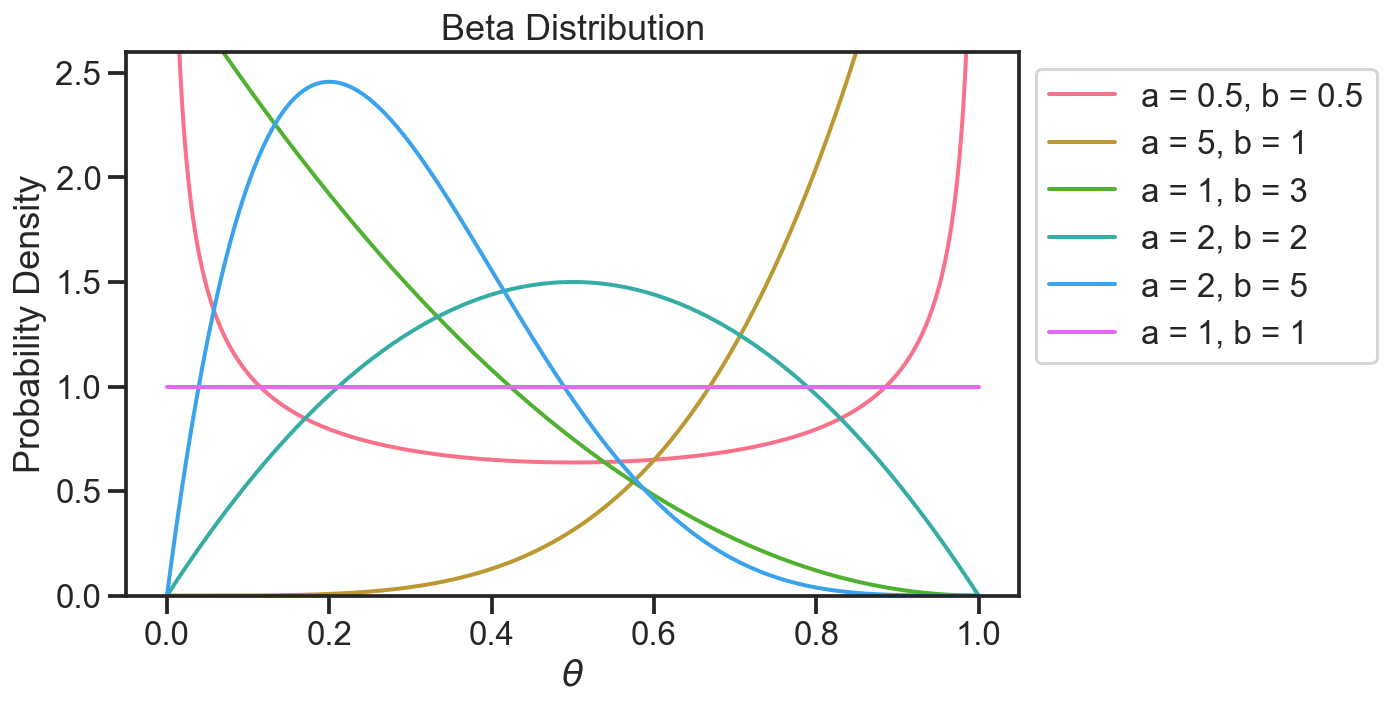

In [37]:
fig, ax = plt.subplots(figsize=(8,5))

# plotting distribution
x = np.linspace(0, 1, 1000)

a = [0.5, 5, 1, 2, 2, 1]
b = [0.5, 1, 3, 2, 5, 1 ]
legend = []

for a, b in zip(a,b):
    y = beta.pdf(x, a, b)
    plt.plot(x, y, lw=2)
    legend.append(f"a = {a}, b = {b}")

plt.xlabel(r'$\theta$')
plt.ylabel('Probability Density')
plt.title('Beta Distribution')
plt.legend(legend, bbox_to_anchor=(1, 1))
plt.ylim(0,2.6)
plt.show()

Which has a PDF defined as:

$$\theta = Beta(a,b) = \frac{\theta^{a-1} (1- \theta)^{b-1}}{B(a,b)}$$

Where we define $B(a,b)$ as:

$$B(a,b) = \frac{\Gamma(a) \Gamma(b)}{\Gamma(a+b)}$$

And $\Gamma$ is defined as:

$$\Gamma(n) = (n-1)!$$

Where $\Gamma$ is really just a generalized factorial for real numbers. 

#### Combine Beta Prior with Bernoulli Likelihood to Solve for Posterior
If we let our prior distribution be the Beta Distribution, does that let us solve for the posterior? Well, let's try and combine it with the likelihood via bayes rule to find out. We can start as follows:

$$P(\theta \mid X) \propto P(X \mid \theta) P(\theta)$$

Where we are using the proportionality symbol because we are not considering the normalizing constant. 

$$
P(\theta \mid X) \propto \Big[ \overbrace{ \prod_{i=1}^N \theta^{x_i}(1-\theta)^{1-x_i} }^\text{Bernoulli likelihood}\Big] 
\overbrace{\theta^{a-1}(1-\theta)^{b-1}}^\text{Beta Prior}
$$

We can then combine like terms so that everything that has $\theta$ on the base goes together, and everything that has $1 - \theta$ goes together:

$$P(\theta \mid X) \propto \theta^{a - 1 + \sum_{i=1}^N x_i} (1 - \theta)^{b - 1 + \sum_{i=1}^N (1 - x_i)} $$

And you may see that this has the same shape as the Beta Distribution! Remember, our normalization constant doesn't matter because it does not depend on $\theta$. In particular, we can see that $P(\theta \mid X)$ is also a Beta distribution:

$$P(\theta \mid X) = Beta(a', b')$$

But the parameters are updated (we will call them $a'$ and $b'$). They are equal to:

$$a' = a + \sum_{i=1}^N x_i$$

$$b' = b + N -\sum_{i=1}^N x_i$$

However, we can also define them in terms of our CTR problem:

$$a' = a + \text{# of clicks}$$

$$b' = b + \text{# of no clicks}$$

#### Interesting Things to Note
One interesting fact about the beta distribution is that the mean is equation to:

$$E(\theta) = \frac{a}{a + b}$$

Which is exactly what the maximum likelihood estimate of the click through rate would have been. However, this solution is far more elegant, because this distribution doesn't require an approximation. 

Another interesting fact arises when we analyze the variance of $\theta$:

$$var(\theta) = \frac{ab}{(a+b)^2 (a+b+1)}$$

Now what is interesting about this? Well, we know that as we collect more data, the larger $a$ and $b$ will become. Therefore, as $a$ and $b$ get bigger, the variance gets smaller. So this automatically follows the same behavior that we observe with the approximate confidence interval, which is that the variance shrinks as we gather more data. 

#### Selecting $a$ and $b$
One question you may have is: How do we choose $a$ and $b$? Well, it turns out that if you set $a = 1$ and $b=1$, the beta distribution is equal to the **Uniform Distribution**. This makes a lot of sense, because if you don't know anything about your CTR prior to the experiment, then all possible CTR's are equally probable. We refer to this as a **non-informative prior**. 

One important fact to keep in mind is that as we collect more and more data, the influence of the prior parameters becomes negligably small. 

#### Summary of what we just did
I want to take a quick moment to summarize what we just did before moving on to the code implementation.
* We started by discussing how we want to know treat the parameter as a random variable with a probability distribution. 
* We identified a _set_ of probability distributions, in this case the Bernoulli and the Beta, such that when you combine them using Bayes rule, the prior _and_ the posterior are the same type of probability distribution. We call these, [**conjugate priors**](https://en.wikipedia.org/wiki/Conjugate_prior).
* Lastly, we showed that the Beta distribution naturally has the same mean as the maximum likelihood CTR of Bernoulli, and the variance automatically shrinks as you collect more data, just as the frequentist confidence interval did.

## 4. Bayesian A/B Testing Algorithm
Finally, we have arrived at the actual implementation of the A/B testing algorithm. We just looked at how we can get a probability distribution of our click through rates, but two questions still remain: 
1. How can we actually use these distributions to solve the explore-exploit dilemma?
2. How can we ensure that our solution is better than that of epsilon-greedy or UCB1?

### 4.1 Sampling
The answer to the above questions is **sampling**. Whenever you generate random numbers, you have to ask, what distribution am I sampling from? In general, most programming languages give you a `rand()` function that provides you with a uniformly distributed number between $[0,1]$. `numpy` gives us a `randn()`, which is a Gaussian with a mean of 0 and a variance of 1. `scipy` gives us the ability to sample from all of the distributions that it contains, the Beta distribution being one of them. 

So, the question now is how does sampling from the Beta Distribution help us? To make the answer to this clear, it helps to consider a few scenarios.

#### Scenario 1
The first scenario is when we have already spent a lot of time exploring, so we have pretty sharp, small variance estimates of our CTR. 

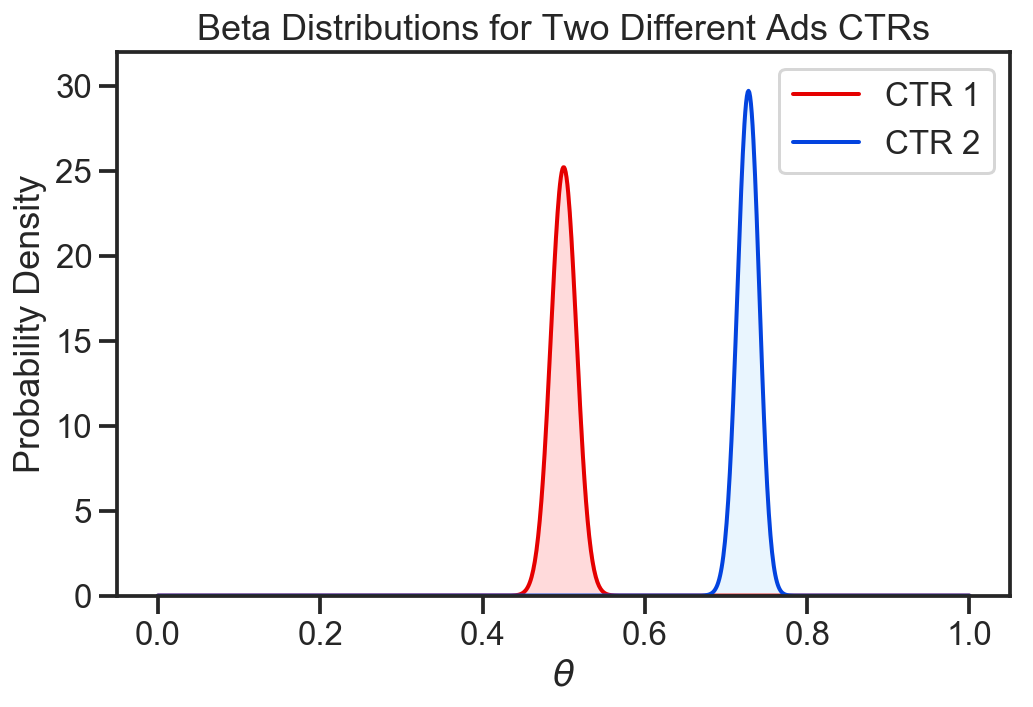

In [94]:
def plot_sampling_scenario(a1, b1, a2, b2):
    fig, ax = plt.subplots(figsize=(8,5))

    x = np.linspace(0, 1, 1000)
    y1 = beta.pdf(x, a1, b1)
    plt.plot(x, y1, c=sns.xkcd_rgb["red"], lw=2)
    plt.fill_between(x, y1, color=sns.xkcd_rgb["light red"], alpha=0.2)

    y2 = beta.pdf(x, a2, b2)
    plt.plot(x, y2, c=sns.xkcd_rgb["blue"], lw=2)
    plt.fill_between(x, y2, color=sns.xkcd_rgb["light blue"], alpha=0.2)
    plt.ylim(0,32)

    plt.xlabel(r'$\theta$')
    plt.ylabel('Probability Density')
    plt.title("Beta Distributions for Two Different Ads CTRs")

    plt.legend(["CTR 1", "CTR 2"], bbox_to_anchor=(1, 1))
    
#     plt.tight_layout()
    
    return plt.show()

plot_sampling_scenario(500, 500, 800, 300)

If we sample a number from both of these beta distributions, we would expect with a very high probability that the one with the higher CTR will give us a larger random number. So, in terms of our Bayesian Bandit problem, we should choose to play the bandit that gives us the largest sample. Note that it is still possible for the worse bandit/advertisement to give us a higher random number, but it becomes increasingly unlikely as distributions get sharper (variance decrases). 

#### Scenario 2
Let's now consider a second scenario. One advertisement has been exploited a lot, so we are very sure of its CTR. However, we have not collected that much data for the other advertisement:

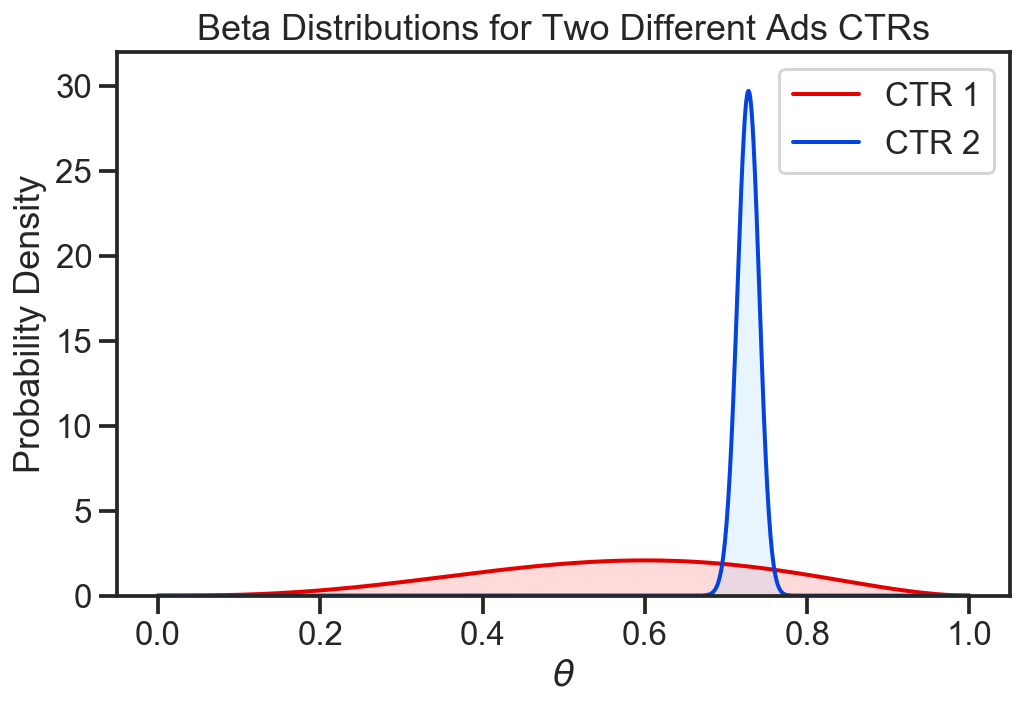

In [95]:
plot_sampling_scenario(4, 3, 800, 300)

Sampling and choosing that advertisement that returned that maximum will help us in this scenario as well! Now, CTR 1, which has a higher variance, has a much higher chance of given us a random number that is larger. So, you can see that:

> It is the distributions themselves that tell us how much to explore and exploit. 

More data gives us less variance, and in turn that leads to less exploration. The same is true in the reverse direction. Less data means more variance, and that means more exploration. 

Now, sticking with this same scenario, notice that if we split the distribution of CTR 1 along the mean of CTR 2, that is has more probability weight (shaded light red) below that of bandit 2. It has a bit of weight above CTR 2 (shaded dark red), but it is still more probable to choose a lower number than it is to choose a higher number (relative to CTR 2). 

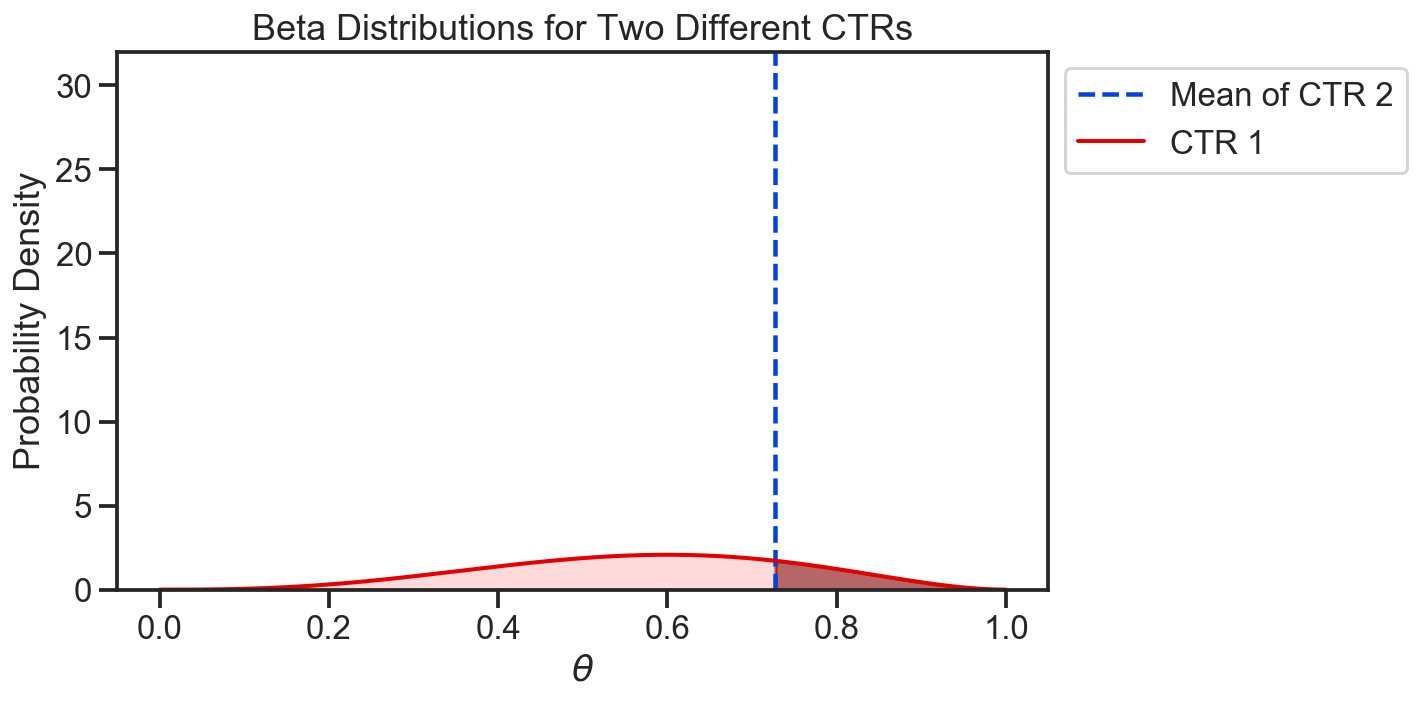

In [96]:
fig, ax = plt.subplots(figsize=(10,5))

a1, b1, a2, b2 = 4, 3, 800, 300
x = np.linspace(0, 1, 1000)

mean, var = beta.stats(a2, b2, moments='mv')
y2 = beta.pdf(x, a2, b2)
plt.axvline(x=mean, color=sns.xkcd_rgb["blue"], linestyle="dashed")
plt.ylim(0,32)

y1 = beta.pdf(x, a1, b1)
plt.plot(x, y1, c=sns.xkcd_rgb["red"], lw=2)
plt.fill_between(x, y1, where=(x < mean), color=sns.xkcd_rgb["light red"], alpha=0.2)
plt.fill_between(x, y1, where=(x > mean), color=sns.xkcd_rgb["dark red"], alpha=0.6)

plt.xlabel(r'$\theta$')
plt.ylabel('Probability Density')
plt.title('Beta Distributions for Two Different CTRs')

plt.legend(["Mean of CTR 2", "CTR 1"], bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

This means that CTR 2 is already pretty good, so we will spend more time exploiting that, and less time exploring. 

#### Scenario 3
Now what if we had a scenario where the CTR with a sharp distribution (CTR 2) we lower than CTR 1. In that case, the probability of exploring the other CTR would be higher because more probability weight is to the right of it.

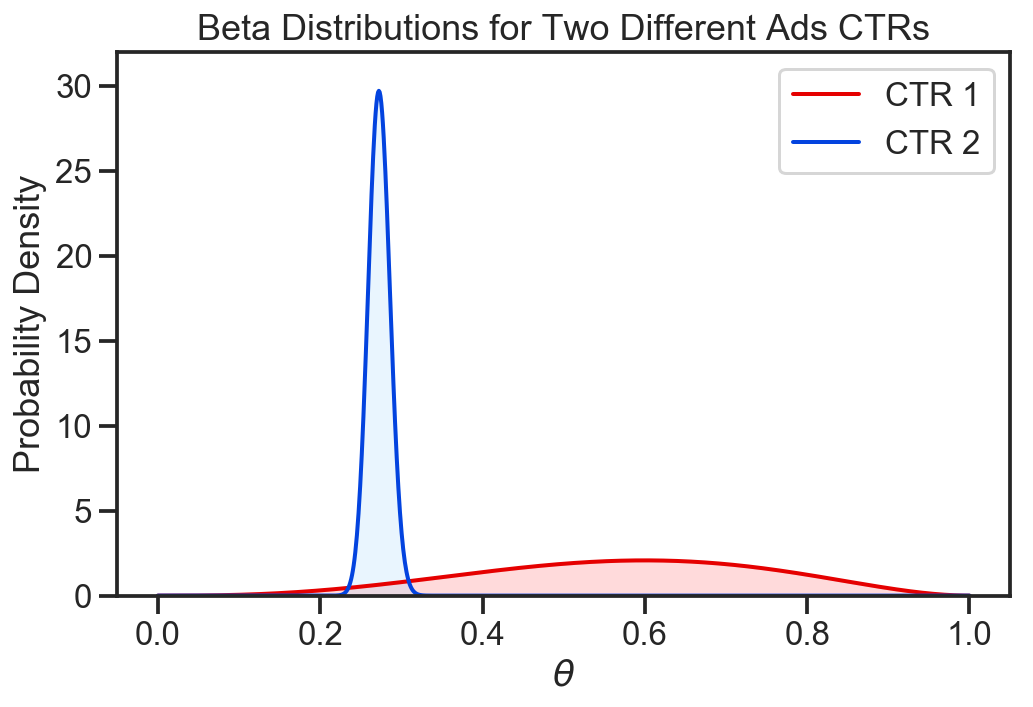

In [97]:
plot_sampling_scenario(4, 3, 300, 800)

#### Thompson Sampling
Note that this method is also refered to **Thompson Sampling**, and it can also be used in the context of reinforcement learning. 

#### Pseudocode
With that said, we can put this all together with a bit of pseudocode as follows:

```
while True: 
    # Draw a random sample from all bandits current Beta(aj, bj)
    j* = bandit that gives us maximum sample, aka choose the bandit that gives us the maximum sample
    x = Play bandit j*, aka pull that bandits arm 
    aj* = aj* + x, update bandits a
    bj* = bj* + 1 - x, update bandits b
```   

Note that this is completely independent from the number of CTRs that their are, which was one of the things we needed to correct from the frequentist A/B test. Also note that I have been using the term bandit and CTR somewhat interchangibly since they serve the same purpose in this overview.

### 4.2 Bayesian A/B in Code
Let's finally put everything together and create our Bayesian A/B test in code. We are going to define the following:

* Class: `Advertisement`
* Probability of winning, `p`
* Beta parameters **`a`** and **`b`**, set equal to **`1`**, which gives the uniform distribution 
* Method **`pull`**: returns **`1`** or **`0`** (a click or a no click)
* Method **`sample`**: samples from class instance current beta distribution
* Method **`update`**: updates instance beta parameters, **`x`** is number of clicks

We can run this experiment for 500 iterations see the outcome visually in the animation below.

In [7]:
NUM_TRIALS = 2000
ADVERTISEMENT_PROBABILITIES = [0.2, 0.5, 0.75] # Ground truth advertisement CTR probabilties, we don't know these!

class Advertisement:
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1
        
    def show_ad(self):
        return np.random.random() < self.p
    
    def sample(self):
        return np.random.beta(self.a, self.b)
    
    def update(self, x):
        self.a += x
        self.b += 1 - x
        
def plot(bandits, trial):
    x = np.linspace(0,1,200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label=f"real p: {b.p}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()
        
def experiment():
    # initializing array of advertisements
    advertisements = [Advertisement(p) for p in ADVERTISEMENT_PROBABILITIES]
    
    # these are point where we will show a plot
    sample_points = [1999]
    
    # loop through each trial 
    for i in range(NUM_TRIALS):
        all_samples = [ad.sample() for ad in advertisements]
        bestb = advertisements[np.argmax(all_samples)]
        if i in sample_points:
            print( "current samples: " , all_samples)
            plot(advertisements, i)
        x = bestb.show_ad()
        bestb.update(x)
    return advertisements

lower_bound = 0
upper_bound = 1

plt.ioff()                          

fig, ax1 = plt.subplots(figsize=(8, 5), dpi=150)       

x_axis = np.arange(lower_bound, upper_bound, 0.001)

# Initialize array of advertisements
advertisements = [Advertisement(p) for p in ADVERTISEMENT_PROBABILITIES]
colors = [sns.xkcd_rgb["red"], sns.xkcd_rgb["blue"], sns.xkcd_rgb["green"]]
shade_colors = [sns.xkcd_rgb["light red"], sns.xkcd_rgb["light blue"], sns.xkcd_rgb["light green"]]
legend = [f"Ground Truth Probability: {ad_prob}" for ad_prob in ADVERTISEMENT_PROBABILITIES]

def animate(trial_num):
    # ------------- Run Experiment -------------
    all_samples = [ad.sample() for ad in advertisements]
    best_ad = advertisements[np.argmax(all_samples)]
    
    x = best_ad.show_ad()
    best_ad.update(x)

    ax1.clear()
    ax1.set_xlim(0, 1)                        
    ax1.set_ylim(0, 30) 
    
    for ad, c, sc in zip(advertisements, colors, shade_colors):
        y = beta.pdf(x_axis, ad.a, ad.b)
        ax1.plot(x_axis, y, c=c)
        ax1.fill_between(x_axis, y, color=sc, alpha=0.3)
        
    ax1.legend(legend, loc=2)
    plt.title(f"Advertisement distributions after {trial_num} trials", pad="10")
    
""" Define steps and create animation object """
step = 1
steps = np.arange(0, 500, step)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

# For rendering html video in cell
# html_video = HTML(
#     animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         interval=100,
#     ).to_html5_video()
# )
# display(html_video)
# gif_video = animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         interval=100,
#     )

# gif_video.save('bayesian_experiment.gif', writer='imagemagick')

plt.close()


<img src="https://drive.google.com/uc?id=1Use2gnw6pCm56ZoBUTFAO7FrVsRBvYpy" width="500">

Above, we see that we have 3 different advertisements, and for the sake of simplicity we can refer to them as the red, blue, and green advertisments (this isn't even that much of a leap-often in Bayesian A/B online testing something as simple of text color may be being compared). The advertisements have a ground truth probability of being clicked of:

$$P(Click \mid red) = 0.2$$

$$P(Click \mid green) = 0.75$$

$$P(Click \mid blue) = 0.5$$

However, keep in mind that we _do not_ actually know that when conducting the experiment. I am simply including it for demonstration/clarity purposes. So, we assign each advertisement a Beta distribution with a $a = 1$ and $b=1$. From a machine learning perspective we can think of these as initial, unlearned parameters (think of how a neural network's weights start off as randomly initialized). 

We then sample from each of these (unlearned) beta distributions, at which point all are equally likely to result in the highest sampled number. Whichever returns the highest number is then selected as as the advertisement to show to a customer. The customer will then either click on that advertisement, or not click on the advertisement. Based on that result, we update $a$ and $b$ of the advertisment that was shown (we update it's beta distribution). We then repeat this process for 500 iterations.

What we see is that for the first 5 to 10 iterations all of the advertisements iterations are nearly the same. However, something very elegant begins to happen over time. Let's look at the red advertisment for a moment. If on iteration 5 the red distribution ends up returning the highest sampled value (which isn't unrealistic since all the of beta distributions begin at the uniform distribution), then what happens? Well, we then actually show the red ad to a user. _But_, the red ad isn't very effective and has only a 20% chance of being clicked on. If the user then doesn't click on it (which is probable), then the number of no clicks for the red ad increases. This subsequently changes the values of $a$ and $b$ for the red beta distribution, making it so that when it is sampled from in the next iteration, it is less probable to return a high sampled number. This can be seen in the flow chart below:

<img src="https://drive.google.com/uc?id=13n5ob76xrQS-ATS4l7BqGpDEDKcz78bN" width="600">

Now, as the number of iterations increases, the fact that the green advertisement has a ground truth probability of 75% to be clicked on is reflected clearly. Let's say that we are once again at iteration 5, and this time the green beta distribution draws the highest sample. This is not unexpected, remember at iteration 5 all beta distributions are very similar. Well, that means that that the green advertisement is shown to a user:

<img src="https://drive.google.com/uc?id=1o8vqRUVJ7NRC2aRi1BEcRTMnFUI4LD_n" width="600">

Remember, users really like the green advertisment, and there is a 75% chance that they are going to click on it. Assuming that they do, at that point the green beta distribution would have it's $a$ and $b$ updated, this time increase the probability of a higher number being sampled from it on the next iteration. This continues and becomes amplified with each iteration. 

What is really cool is that as the number of iterations increases, the variance of the green beta can clearly be seen decrease (it becomes a tighter/skinnier distribution). It begins to form a very tight distribution around 0.75-the true parameter! This means that we essentially were able to the **learn** true parameter of the green advertisement probability!

**How did we just use Bayes Rule?** <br>
Now, you may be wondering how exactly we just used bayes rule? Bayes rule, as we have seen several times, involves multiplying the prior by the likelihood in order to get the posterior. So, where exactly did that occur? Remember, we actually derived that earlier! We found that the beta and bernoulli distribution formed what is known as a *conjugate prior* pair, and that multiplying them together results in a beta Distribution. The new beta distribution is based on updated $a$ and $b$ parameters. So, bayes rule was baked into this process based on our prior derivation. 

## 5. The Online Nature of A/B Testing

### 5.1 Bayesian Sampling
I want to take a moment and pause to consider how far we have come at this point. 

* We started with traditional A/B testing, making use of all sorts of approximations, awkwardly deciding how many samples you need to collect with more approximations, and then finally running a full experiment without any adaptation to results collected so far.
* If we wanted to stop early, frequentist statistics told us that we would not get a valid result.
* Now, we have a way to create an adaptive system! Which, if you think about it, doesn't even really require any kind of test; we are just able to start it and let it run.
* It eventually converges, so that you are doing the best possible thing given the data that you have collected. 
* In other words, there is no threshold at which the results become valid, rather you will **naturally converge to equilibrium**. 

Clearly, we have made some drastic improvements, while at the same time making our methodology far easier to explain, and elegant to implement.

### 5.2 The Online Nature of Bayesian Methods
Now, one very interesting aspect of the bayesian sampling method is that your measurements become more accurate after every single sample you collect. Why exactly is that? Well, as mentioned earlier, you can see that we don't just update a bandits $a$ and $b$ parameters after collecting all the data; rather, we update it after every time we pulled an arm! Put another way, the **posterior** that we have now **becomes the prior** when we incorporate even more data:

$$P(\theta_t \mid X) = P(X_t \mid \theta_{t-1}) P(\theta_{t-1})$$

$$P(\theta_{t+1} \mid X) = P(X_{t+1} \mid \theta_{t}) P(\theta_{t})$$

We can compare this to a traditional machine learning model, where you fit all of your training data at the same time:

```
fit(Xtrain, Ytrain)
```

If we get more data in that case, we need to retrain from scratch. With out bayesian sampling approach, we just add a number to $a$ and a number to $b$. This is an example of what is known as **online learning**. The model will learn and improve after every single sample. Additionally, there won't be any RAM issues because $a$ and $b$ take up constant space. In the same vein, there will be no speed issues either. 

In a sense, this is more similar to how humans and animals learn. Specifically, we take our most recent experience and form some opinion about it. Never do we take every experience we have ever had and try to reach some global optimum. In fact, we can't even do that because our memory systems are imperfect. All said and done, there are a lot of satisfying results from using the bayesian method! 

## 6. Finding a Threshold without $p$-values
Now, even though Bayesian Testing is very efficient, it still takes up resources. For instance, we must store $a$ and $b$ somewhere (a database), generate random numbers for the bandits, and so on. So, if we are certain that one advertisement is better than another, why not just display that advertisement in a static way? 

current samples:  [0.04495668840020105, 0.5794254577880681, 0.746496758719852]


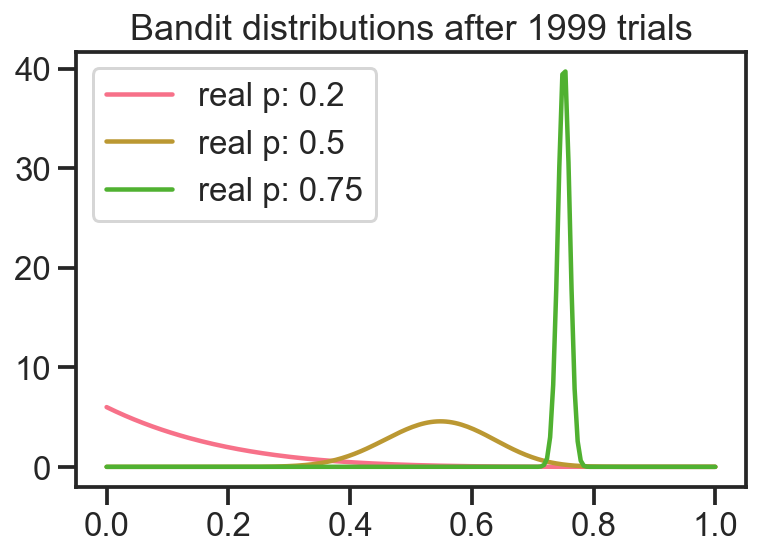

In [8]:
advertisements = experiment()

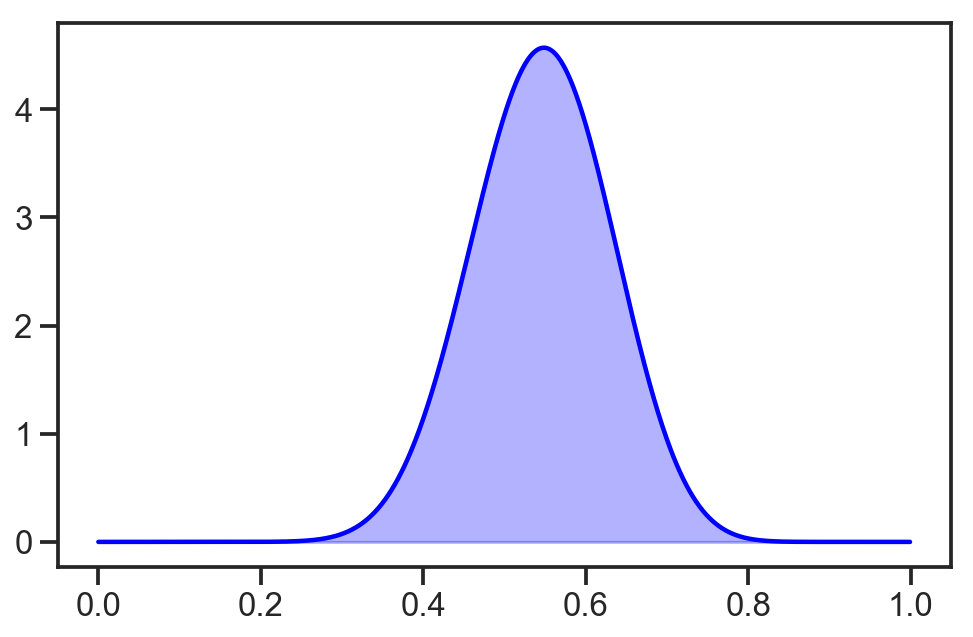

In [21]:
blue_ad = advertisements[1]
fig, ax1 = plt.subplots(figsize=(8, 5))       

x_axis = np.arange(lower_bound, upper_bound, 0.001)
y = beta.pdf(x_axis, blue_ad.a, blue_ad.b)
ax1.plot(x_axis, y, c="blue")
ax1.fill_between(x_axis, y, color="blue", alpha=0.3)
plt.show()

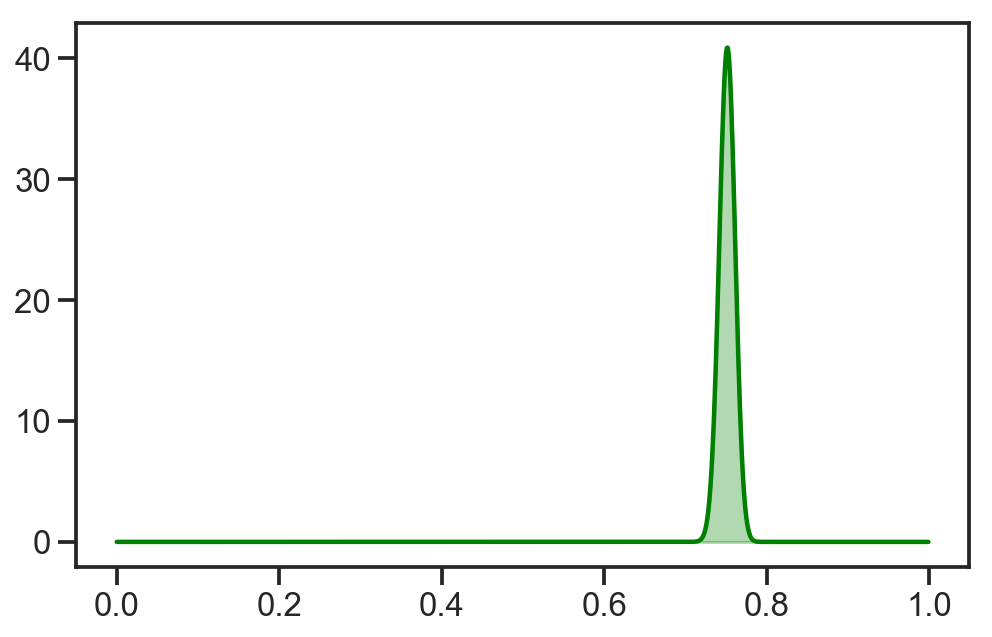

In [22]:
green_ad = advertisements[2]
fig, ax1 = plt.subplots(figsize=(8, 5))       

x_axis = np.arange(lower_bound, upper_bound, 0.001)
y = beta.pdf(x_axis, green_ad.a, green_ad.b)
ax1.plot(x_axis, y, c="green")
ax1.fill_between(x_axis, y, color="green", alpha=0.3)
plt.show()

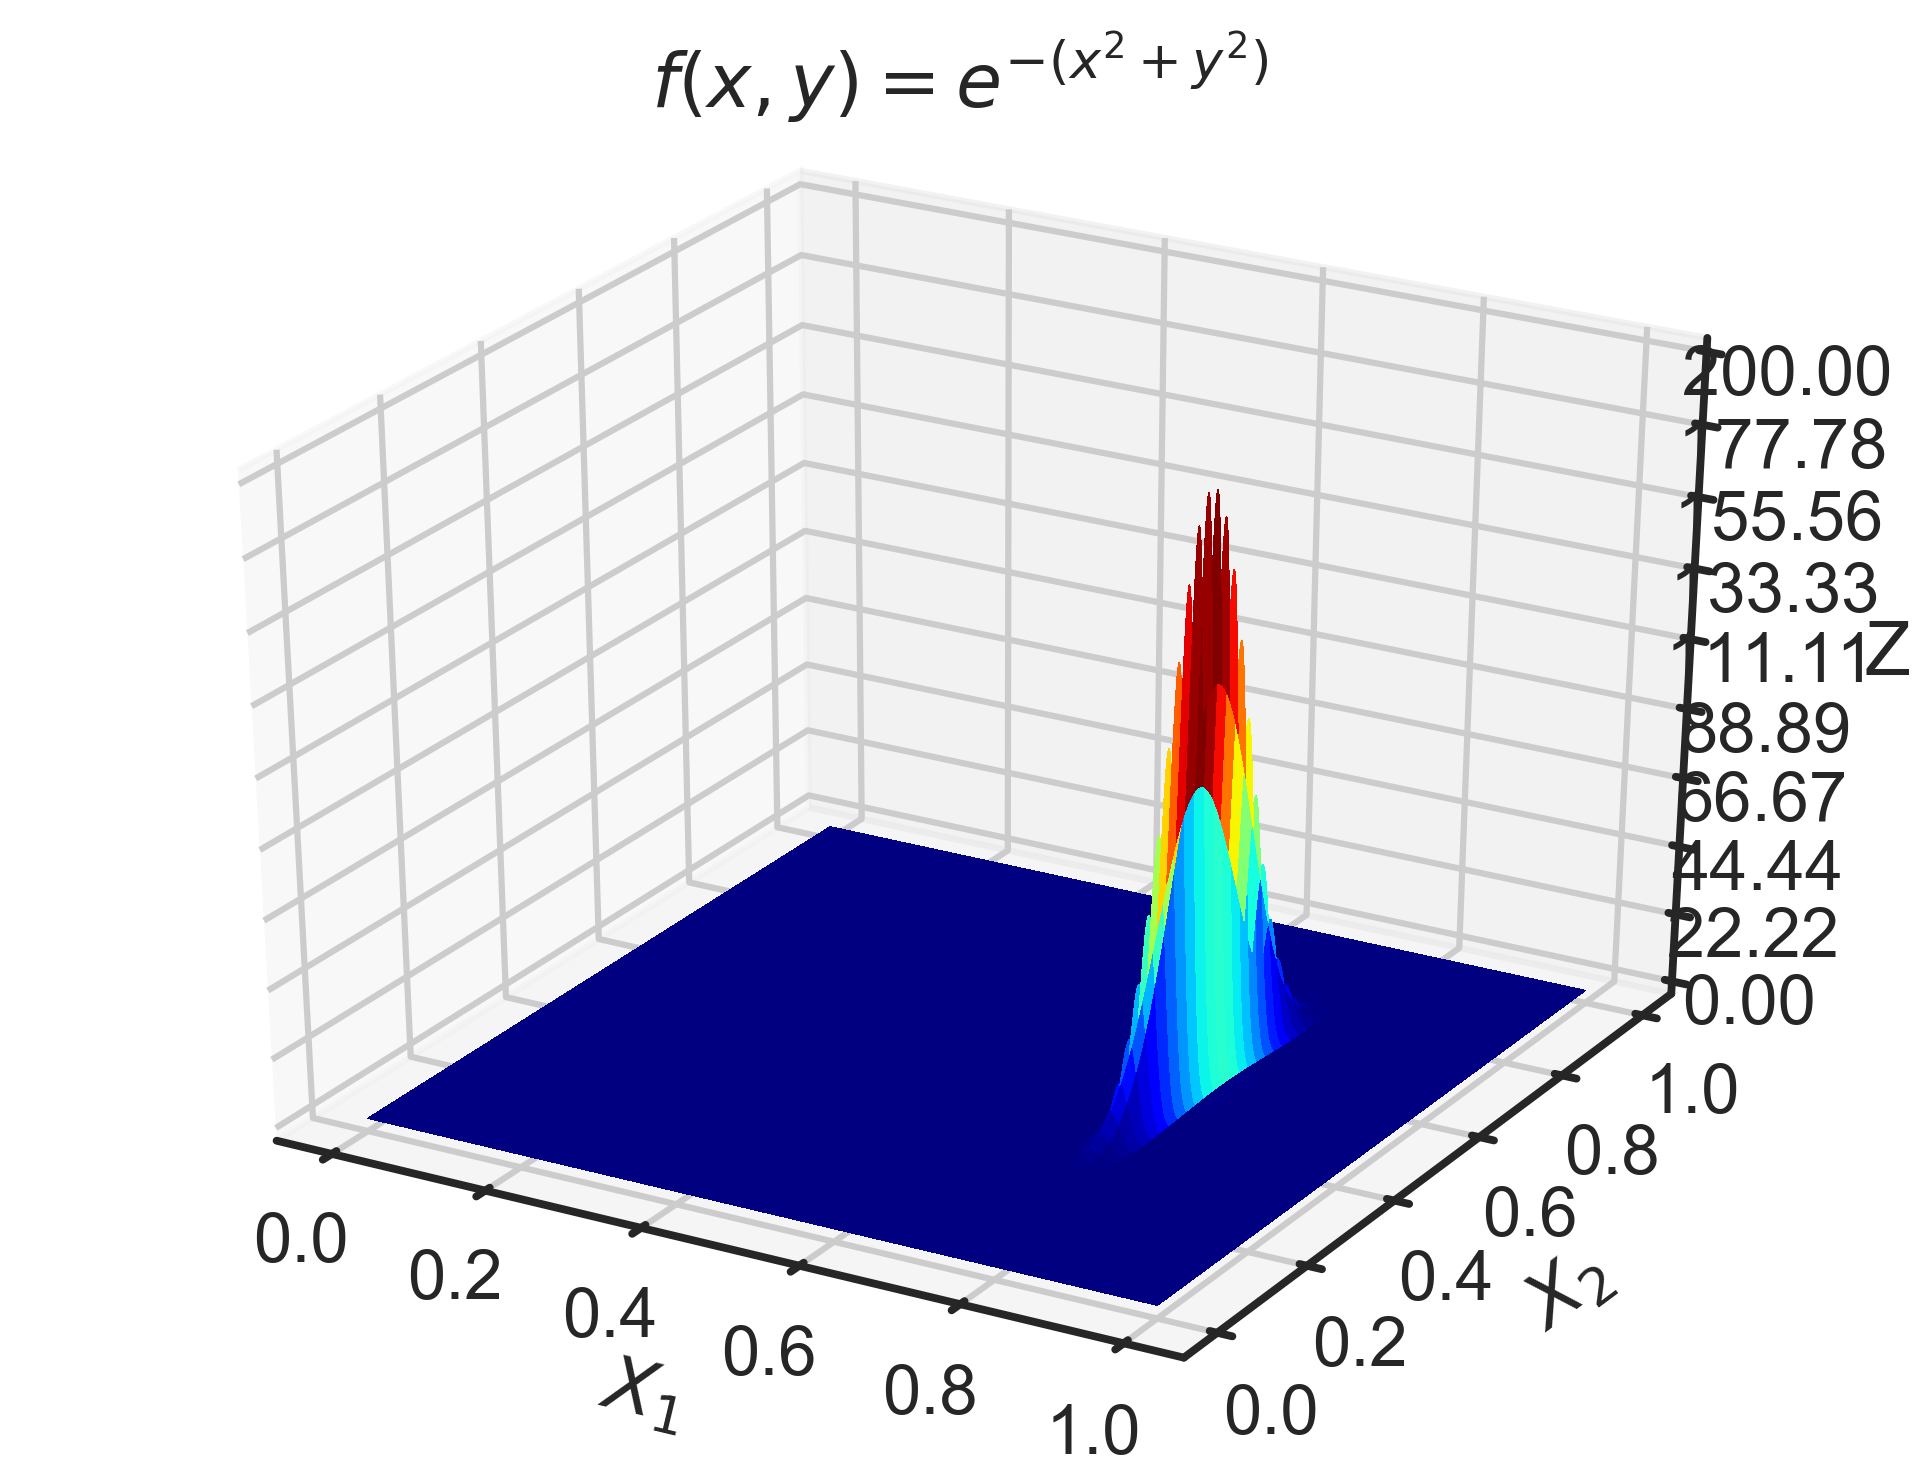

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.gca(projection='3d')

# Make data.
X_1 = np.arange(0, 1, 0.0001)
X_2 = np.arange(0, 1, 0.0001)
X_1, X_2 = np.meshgrid(X_1, X_2)
Z = beta.pdf(X_1, green_ad.a, green_ad.b) * beta.pdf(X_2, blue_ad.a, blue_ad.b)

# Plot the surface.
surf = ax.plot_surface(X_1, X_2, Z, cmap=cm.jet,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 200)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Labels
ax.set_xlabel(f'$X_1$', labelpad=8)
ax.set_ylabel(f'$X_2$', labelpad=8)
ax.set_zlabel('Z', labelpad=8)
ax.set_title('$f(x,y) = e^{-(x^2 + y^2)}$', pad="20")

plt.show()

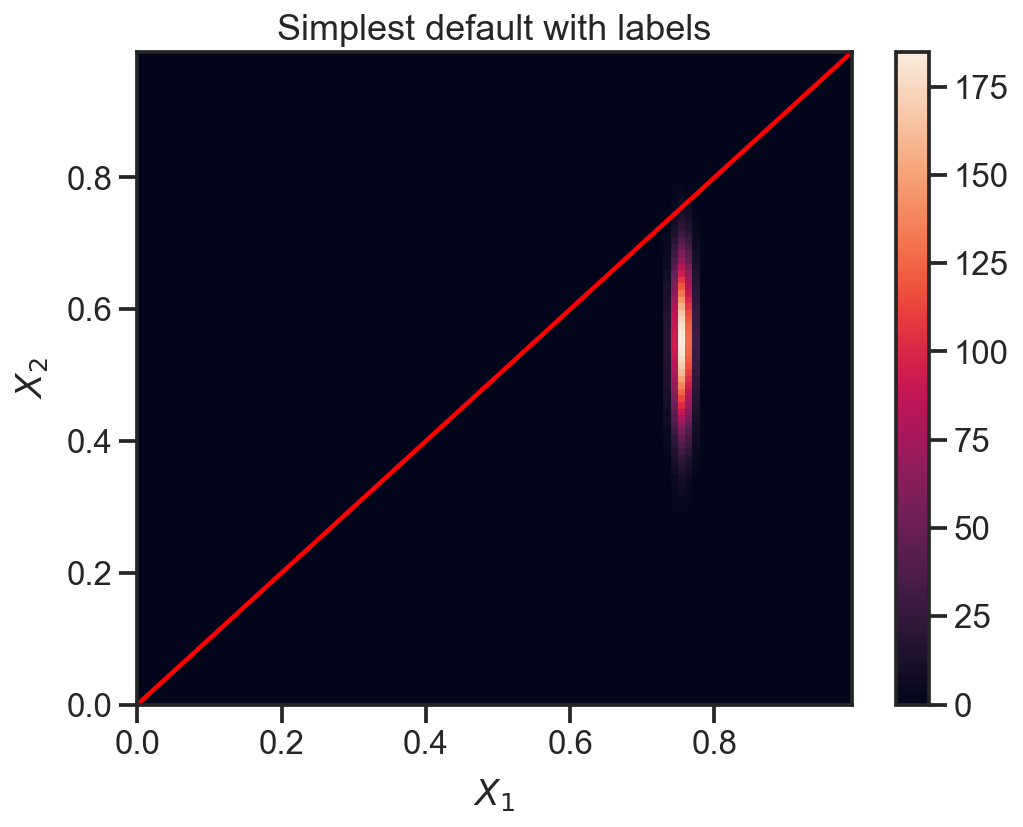

In [78]:
def plot_func():
    fig, ax = plt.subplots(figsize=(8, 6))     

    X_1 = np.arange(0, 1, 0.01)
    X_2 = np.arange(0, 1, 0.01)
    X_1, X_2 = np.meshgrid(X_1, X_2)
    Z = beta.pdf(X_1, green_ad.a, green_ad.b) * beta.pdf(X_2, blue_ad.a, blue_ad.b)
    c = ax.pcolormesh(X_1, X_2, Z)
    fig.colorbar(c, ax=ax)

    y = X_1[0]
    ax.plot(X_1[0], y, color="red")

    ax.set_xlabel(f'$X_1$', labelpad=8)
    ax.set_ylabel(f'$X_2$', labelpad=8)
    ax.set_title('Simplest default with labels')
    plt.show()

plot_func()

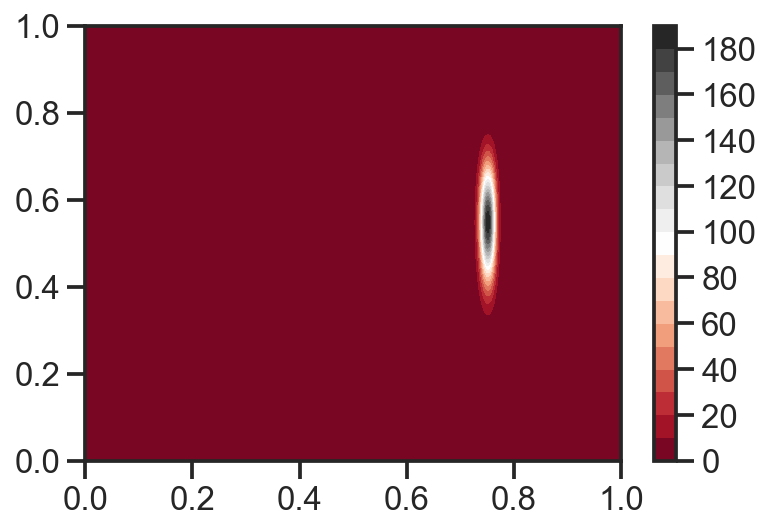

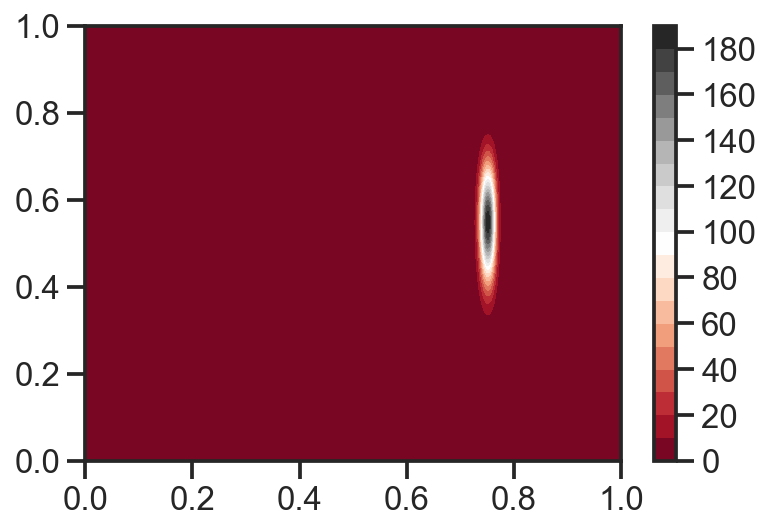

KeyboardInterrupt: 

In [67]:
plt.contourf(X_1, X_2, Z, 20, cmap='RdGy')
plt.colorbar();
plt.show()

In [87]:
NUM_TRIALS = 2000
# ONLY USING BLUE AND GREEN RIGHT NOW
ADVERTISEMENT_PROBABILITIES = [0.75, 0.5] # Ground truth advertisement CTR probabilties, we don't know these!

lower_bound = 0
upper_bound = 1

plt.ioff()                          

fig, ax1 = plt.subplots(figsize=(8, 6), dpi=150)       

X_1 = np.arange(0, 1, 0.005)
X_2 = np.arange(0, 1, 0.005)
X_1, X_2 = np.meshgrid(X_1, X_2)

# Initialize array of advertisements
advertisements = [Advertisement(p) for p in ADVERTISEMENT_PROBABILITIES]
colors = [sns.xkcd_rgb["blue"], sns.xkcd_rgb["green"]]
shade_colors = [sns.xkcd_rgb["light blue"], sns.xkcd_rgb["light green"]]
legend = [f"Ground Truth Probability: {ad_prob}" for ad_prob in ADVERTISEMENT_PROBABILITIES]

def animate(trial_num):
    # ------------- Run Experiment -------------
    all_samples = [ad.sample() for ad in advertisements]
    best_ad = advertisements[np.argmax(all_samples)]
    
    x = best_ad.show_ad()
    best_ad.update(x)

    ax1.clear()
    
#     for ad, c, sc in zip(advertisements, colors, shade_colors):
    Z = (
        beta.pdf(X_1, advertisements[0].a, advertisements[0].b) * 
        beta.pdf(X_2, advertisements[1].a, advertisements[1].b)
    )
#     Z = beta.pdf(X_1, green_ad.a, green_ad.b) * beta.pdf(X_2, blue_ad.a, blue_ad.b)

#     ax1.contourf(X_1, X_2, Z, 20, cmap='RdGy')
#     ax1.colorbar()   

    ax1.pcolormesh(X_1, X_2, Z)
    y = X_1[0]
    ax1.plot(X_1[0], y, color="red")
#     fig.colorbar(c, ax=ax)
        
    ax1.legend(legend, loc=2)
    plt.title(f"Advertisement distributions after {trial_num} trials", pad="10")
    
""" Define steps and create animation object """
step = 1
steps = np.arange(0, 500, step)

plt.tight_layout()
plt.subplots_adjust(top=0.9)

# For rendering html video in cell
html_video = HTML(
    animation.FuncAnimation(
        fig,
        animate,
        steps,
        interval=100,
    ).to_html5_video()
)
display(html_video)
# gif_video = animation.FuncAnimation(
#         fig,
#         animate,
#         steps,
#         interval=100,
#     )

# gif_video.save('bayesian_experiment.gif', writer='imagemagick')

plt.close()
